In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from IPython import display
%matplotlib inline

In [2]:
def change_range(values, vmin=0, vmax=1):
    start_zero = values - np.min(values)
    return (start_zero / (np.max(start_zero) + 1e-7)) * (vmax - vmin) + vmin

In [3]:
class GridWorld:
    terrain_color = dict(normal=[127/360, 0, 96/100],
                         objective=[26/360, 100/100, 100/100],
                         cliff=[247/360, 92/100, 70/100],
                         player=[344/360, 93/100, 100/100])
        
    def __init__(self):
        self.player = None
        self._create_grid()  
        self._draw_grid()
        self.num_steps = 0
        
    def _create_grid(self, initial_grid=None):
        self.grid = self.terrain_color['normal'] * np.ones((4, 12, 3))
        self._add_objectives(self.grid)
        
    def _add_objectives(self, grid):
        grid[-1, 1:11] = self.terrain_color['cliff']
        grid[-1, -1] = self.terrain_color['objective']
        
    def _draw_grid(self):
        self.fig, self.ax = plt.subplots(figsize=(12, 4))
        self.ax.grid(which='minor')       
        self.q_texts = [self.ax.text(*self._id_to_position(i)[::-1], '0',
                                     fontsize=11, verticalalignment='center', 
                                     horizontalalignment='center') for i in range(12 * 4)]     
         
        self.im = self.ax.imshow(hsv_to_rgb(self.grid), cmap='terrain',
                                 interpolation='nearest', vmin=0, vmax=1)        
        self.ax.set_xticks(np.arange(12))
        self.ax.set_xticks(np.arange(12) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(4))
        self.ax.set_yticks(np.arange(4) - 0.5, minor=True)
        
    def reset(self):
        self.player = (3, 0)    
        self.num_steps = 0    
        return self._position_to_id(self.player)
    
    def step(self, action):
        # Possible actions
        if action == 0 and self.player[0] > 0:
            self.player = (self.player[0] - 1, self.player[1])
        if action == 1 and self.player[0] < 3:
            self.player = (self.player[0] + 1, self.player[1])
        if action == 2 and self.player[1] < 11:
            self.player = (self.player[0], self.player[1] + 1)
        if action == 3 and self.player[1] > 0:
            self.player = (self.player[0], self.player[1] - 1)
        
        self.num_steps = self.num_steps + 1
        # Rules
        if all(self.grid[self.player] == self.terrain_color['cliff']):
            reward = -100
            done = True
        elif all(self.grid[self.player] == self.terrain_color['objective']):
            reward = 0
            done = True
        else:
            reward = -1
            done = False
            
        return self._position_to_id(self.player), reward, done
    
    def _position_to_id(self, pos):
        ''' Maps a position in x,y coordinates to a unique ID '''
        return pos[0] * 12 + pos[1]
    
    def _id_to_position(self, idx):
        return (idx // 12), (idx % 12)
        
    def render(self, q_values=None, action=None, max_q=False, colorize_q=False):
        assert self.player is not None, 'You first need to call .reset()'  
        
        if colorize_q:
            assert q_values is not None, 'q_values must not be None for using colorize_q'            
            grid = self.terrain_color['normal'] * np.ones((4, 12, 3))
            values = change_range(np.max(q_values, -1)).reshape(4, 12)
            grid[:, :, 1] = values
            self._add_objectives(grid)
        else:            
            grid = self.grid.copy()
            
        grid[self.player] = self.terrain_color['player']       
        self.im.set_data(hsv_to_rgb(grid))
        display.display(plt.gcf())
        display.clear_output(wait=True)
               
        if q_values is not None:
            xs = np.repeat(np.arange(12), 4)
            ys = np.tile(np.arange(4), 12)  
            
            for i, text in enumerate(self.q_texts):
                if max_q:
                    q = max(q_values[i])    
                    txt = '{:.2f}'.format(q)
                    text.set_text(txt)
                else:                
                    actions = ['U', 'D', 'R', 'L']
                    txt = '\n'.join(['{}: {:.2f}'.format(k, q) for k, q in zip(actions, q_values[i])])
                    text.set_text(txt)
                
        if action is not None:
            self.ax.set_title(action, color='r', weight='bold', fontsize=32)

#         plt.pause(0.01)

In [4]:
def egreedy_policy(q_values, state, epsilon=0.1):
    ''' 
    Choose an action based on a epsilon greedy policy.    
    A random action is selected with epsilon probability, else select the best action.    
    '''
    if np.random.random() < epsilon:
        return np.random.choice(4)
    else:
        return np.argmax(q_values[state])

In [5]:
def q_learning(env, num_episodes=500, render=True, exploration_rate=0.1,
               learning_rate=0.5, gamma=0.9):    
    q_values = np.zeros((num_states, num_actions))
    ep_rewards = []
    
    for _ in range(num_episodes):
        state = env.reset()    
        done = False
        reward_sum = 0

        while not done:            
            # Choose action        
            action = egreedy_policy(q_values, state, exploration_rate)
            # Do the action
            next_state, reward, done = env.step(action)
            reward_sum += reward
            # Update q_values       
            td_target = reward + 0.9 * np.max(q_values[next_state])
            td_error = td_target - q_values[state][action]
            q_values[state][action] += learning_rate * td_error
            # Update state
            state = next_state

            if render:
                env.render(q_values, action=actions[action], colorize_q=True)
            
        ep_rewards.append(reward_sum)
    
    return ep_rewards, q_values

In [6]:
def sarsa(env, num_episodes=500, render=True, exploration_rate=0.1,
          learning_rate=0.5, gamma=0.9):
    q_values_sarsa = np.zeros((num_states, num_actions))
    ep_rewards = []
    
    for _ in range(num_episodes):
        state = env.reset()    
        done = False
        reward_sum = 0
        # Choose action        
        action = egreedy_policy(q_values_sarsa, state, exploration_rate)

        while not done:        
            # Do the action
            next_state, reward, done = env.step(action)
            reward_sum += reward
            
            # Choose next action
            next_action = egreedy_policy(q_values_sarsa, next_state, exploration_rate)
            # Next q value is the value of the next action
            td_target = reward + gamma * q_values_sarsa[next_state][next_action]
            td_error = td_target - q_values_sarsa[state][action]
            # Update q value
            q_values_sarsa[state][action] += learning_rate * td_error

            # Update state and action        
            state = next_state
            action = next_action
            
            if render:
                env.render(q_values, action=actions[action], colorize_q=True)
                
        ep_rewards.append(reward_sum)
        
    return ep_rewards, q_values_sarsa

In [7]:
def play(q_values):
	# simulate the environent using the learned Q values
    env = GridWorld()
    state = env.reset()
    done = False

    while not done:    
        # Select action
        action = egreedy_policy(q_values, state, 0.0)
        # Do the action
        next_state, reward, done = env.step(action)  

        # Update state and action        
        state = next_state  
        
        env.render(q_values=q_values, action=actions[action], colorize_q=True)

In [8]:
UP = 0
DOWN = 1
RIGHT = 2
LEFT = 3
actions = ['UP', 'DOWN', 'RIGHT', 'LEFT']

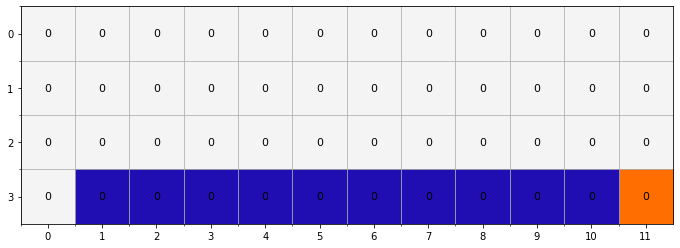

In [9]:
### Define the environment
env = GridWorld()
num_states = 4 * 12  #The number of states in simply the number of "squares" in our grid world, in this case 4 * 12
num_actions = 4 # We have 4 possible actions, up, down, right and left

In [10]:
### Q-learning for cliff walk
q_learning_rewards, q_values = q_learning(env, gamma=0.9, learning_rate=1, render=False)
env.render(q_values, colorize_q=True)

<Figure size 432x288 with 0 Axes>

In [11]:
q_learning_rewards, _ = zip(*[q_learning(env, render=False, exploration_rate=0.1, learning_rate=1) for _ in range(10)])
avg_rewards = np.mean(q_learning_rewards, axis=0)
mean_reward = [np.mean(avg_rewards)] * len(avg_rewards)

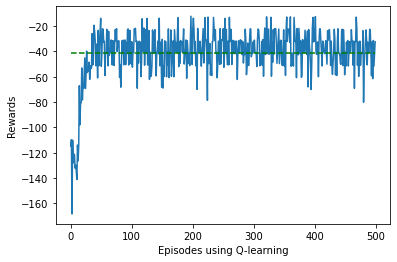

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel('Episodes using Q-learning')
ax.set_ylabel('Rewards')
ax.plot(avg_rewards)
ax.plot(mean_reward, 'g--')

In [13]:
print('Mean Reward using Q-Learning: {}'.format(mean_reward[0]))

Mean Reward using Q-Learning: -41.3928


In [14]:
### Sarsa learning for cliff walk
sarsa_rewards, q_values_sarsa = sarsa(env, render=False, learning_rate=0.5, gamma=0.99)

In [15]:
sarsa_rewards, _ = zip(*[sarsa(env, render=False, exploration_rate=0.2) for _ in range(10)])
avg_rewards = np.mean(sarsa_rewards, axis=0)
mean_reward = [np.mean(avg_rewards)] * len(avg_rewards)

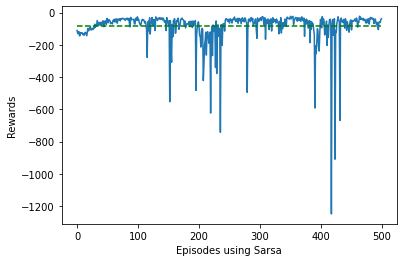

In [16]:
fig, ax = plt.subplots()
ax.set_xlabel('Episodes using Sarsa')
ax.set_ylabel('Rewards')
ax.plot(avg_rewards)
ax.plot(mean_reward, 'g--')

In [17]:
print('Mean Reward using Sarsa: {}'.format(mean_reward[0]))

Mean Reward using Sarsa: -83.851


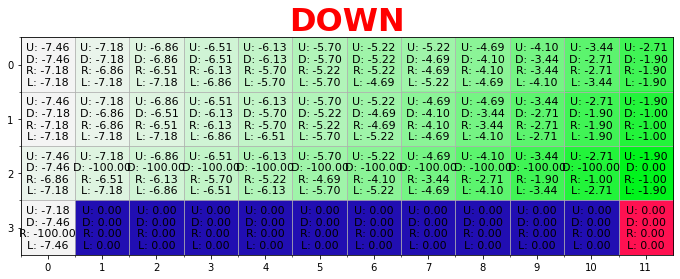

In [18]:
# visualize the episode in inference for Q-learing and Sarsa-learning
play(q_values)

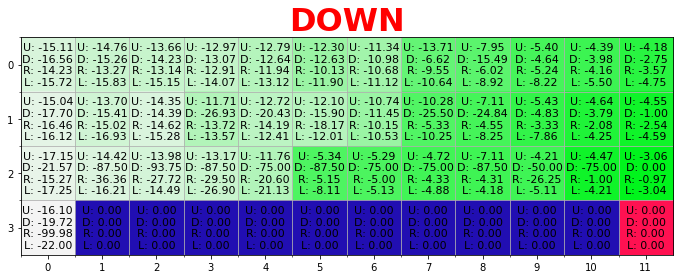

In [19]:
play(q_values_sarsa)